In [1]:
"""
# Header ------------------------------------------------------------------
"""
import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from core import *
from model import build
from scipy.stats import poisson
np.set_printoptions(precision=10)

## Serius

In [2]:
# data ----------------------------------------------------------

np.random.seed(123)

df = pd.read_csv("experiment1.csv")

In [3]:
models=build()

In [4]:
T = np.unique(df["Year"]).shape[0]

d15n=df.loc[ df["Year"]== 2015, ["Population"] ].values
d16n=df.loc[ df["Year"]== 2016, ["Population"] ].values

d15y=df.loc[ df["Year"]== 2015, ["Property crime"] ].values
d16y=df.loc[ df["Year"]== 2016, ["Property crime"] ].values

n=np.array([d15n, d16n]).squeeze(-1).T
y=np.array([d15y, d16y]).squeeze(-1).T

df["Regions"] = pd.Categorical(df["Regions"])
df["Year"] = pd.Categorical(df["Year"])

region = df["Regions"].cat.codes.values.reshape(-1)
year = df["Year"].cat.codes.values.reshape(-1)

nregions = np.unique(region).shape[0]
nstates = n.shape[0]

In [5]:
def eplot(model, y, n, it = 10000, chains=4,sslice =1000, debug = False):
    samples = sample(model[0], model[2], varnames=model[1], chains=chains, trials=it)
    
    #if debug:
    #    plt.hist([np.array(samples['y_pred'][:,:,-sslice,:].ravel()), 
    #    np.array(y.ravel())],bins=10,histtype='bar',density=True,label=("predicted","true"))

    #    plt.legend(loc="upper right")
    #    plt.show()
        
    y_pred = np.mean( samples['y_pred'][:,:,-sslice:,:], axis=(-1,-2) )
    theta_mean = np.mean( samples['theta'][:,:,-sslice:,:], axis=(-1,-2) )
    theta_median = np.median( samples['theta'][:,:,-sslice:,:], axis=(-1,-2) )
    loglikl = np.mean(
        samples['log.lik'][:,-sslice:,:]
        .ravel()
    )
    
    loglikl_mean = loglikl_median = loglikl
    
    y_predmean = n.ravel() * theta_mean.ravel()
    mse_mean = np.sum(((y.ravel()-y_predmean)/y.ravel())**2) 
    
    y_predmd = n.ravel() * theta_median.ravel()
    mse_md = np.sum(((y.ravel()-y_predmd)/y.ravel())**2) 
    
    aic_mean = 2* model[3] - 2 * loglikl_mean
    aic_md = 2* model[3] - 2 * loglikl_median
    sic_mean = 2* np.log(len(y.ravel()))*model[3] - 2 * loglikl_mean
    sic_md = 2* np.log(len(y.ravel()))*model[3] - 2 * loglikl_median
    
    print("######################")
    
    print("### mean: ---")
    print("Log likelihood: " + str(loglikl_mean)) 
    print("aic: "+ str(aic_mean))
    print("sic: "+ str(sic_mean))
    print("chi-square : " + str(mse_mean))
    
    print("### median: ---")
    print("Log likelihood: " + str(loglikl_median))
    print("aic: "+ str(aic_md))
    print("sic: "+ str(sic_md))
    print("chi-square : " + str(mse_md))
    
    print("### sampled: ---")
    print("mse: " + str(np.sum(((y.ravel()-y_pred.ravel())/y.ravel())**2) ) )
    
    print("######################")
    if debug:
        analyse_fit(model[1],samples)
    
    plot_predictive(
        n.ravel(),
        y.ravel(), 
        y_pred.ravel())
    
    eps = np.mean( ( y - y_pred) ** 2 / y ) 
    print(eps)
    
    plt.show()

#### Results

fiss - 33.88

fics - 45.816

fccs - 52.57

fisl - 113

fcfl - 7.12

fffl - 7.13

fcfq - 7.10

fcfs - 29.23

fsis - 1976

fcis - 1976

ffis - 1976

fiis - 4106



# notation

## nation, region, state, time
### time - i - ar1 lin, q - ar1 quad, s - stationary 
### region, state, natio - i - independent, f - fixed effect, c - car effect, s - sar effect

In [8]:
eplot(models["fcfq"], y = y, n=n, it=30000, sslice=4000, debug=True)

adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 8336 of 120000, elapsed 0:00:08, remaining 0:01:48


KeyboardInterrupt: 

In [13]:
eplot(models["fiss"], y = y, n=n, it=40000, sslice=4000, debug=True)

adapting: iterations 4 of 4000, elapsed 0:00:07, remaining 1:54:25


KeyboardInterrupt: 

adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 14712 of 160000, elapsed 0:00:09, remaining 0:01:30
sampling: iterations 22768 of 160000, elapsed 0:00:15, remaining 0:01:28
sampling: iterations 30600 of 160000, elapsed 0:00:25, remaining 0:01:47
sampling: iterations 42948 of 160000, elapsed 0:00:33, remaining 0:01:30
sampling: iterations 56156 of 160000, elapsed 0:00:42, remaining 0:01:18
sampling: iterations 69632 of 160000, elapsed 0:00:50, remaining 0:01:05
sampling: iterations 83532 of 160000, elapsed 0:00:58, remaining 0:00:53
sampling: iterations 98016 of 160000, elapsed 0:01:06, remaining 0:00:42
sampling: iterations 113064 of 160000, elapsed 0:01:13, remaining 0:00:30
sampling: iterations 128584 of 160000, elapsed 0:01:21, remaining 0:00:20
sampling: iterations 144492 of 160000, elapsed 0:01:29, remaining 0:00:10
sampling: iterations 160000 of 160000, elapsed 0:01:39, remaining 0:00:00
sampling: iterations 160000 of 160000, elapsed 0:0

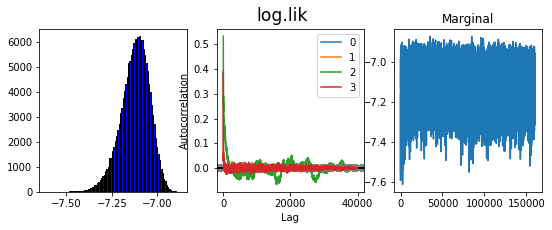

chi-square : 0.0017820337496947064
0.21596881116989644


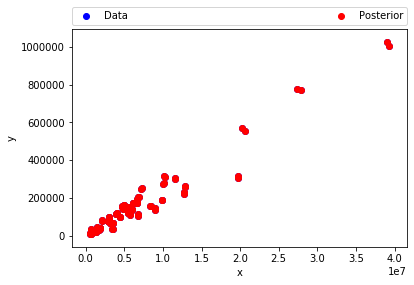

In [6]:
eplot(models["fffl"], y = y, n=n, it=40000, sslice=4000, debug=True)

## Model

$C_{it}$ is the criminal population for a given state $i$ in year $t$.


$ C_{it} \propto Bin( d_{it} , n_{it})$

$ d_{ij} = \gamma_{it} + \gamma_{i}$

$ \gamma_{it} = \beta_0 + \beta_1\epsilon c_{it-1}$

$ \epsilon c_{eit-1} = C_{it-1} - E[C_{it-1}]$

$\gamma_{i} = d_0 + \mu_i + \alpha_{r(i)}$

$Y_{it}$ is the property crime for a given state $i$ in year $t$

$ Y_{it} \propto Poisson( C_{it} p_{it})$

$ p_{ij} = \tau_{it} + \tau_{i}$

$ \tau_{it} = \beta'_0 + \beta'_1\epsilon y_{it-1}$

$ \epsilon y_{eit-1} = C_{it-1} - E[C_{it-1}]$

$\tau_{i} = p_0 + \pi_i + \alpha' _{r(i)}$

## Prior


In [6]:
model = models["fcfl"]
samples = sample(model[0], model[2], varnames=model[1], chains=4, trials=10000)

adapting: iterations 4000 of 4000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 14152 of 40000, elapsed 0:00:09, remaining 0:00:16
sampling: iterations 30740 of 40000, elapsed 0:00:18, remaining 0:00:05
sampling: iterations 40000 of 40000, elapsed 0:00:24, remaining 0:00:00
sampling: iterations 40000 of 40000, elapsed 0:00:24, remaining 0:00:00


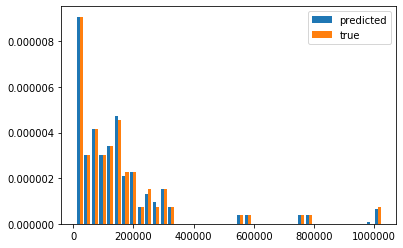

In [70]:

plt.hist([np.array(samples['y_pred'][:,:,-4000,:].ravel()), 
        np.array(y.ravel())],bins=40,histtype='bar',density=True,label=("predicted","true"))

plt.legend(loc="upper right")
plt.show()

In [7]:
1514563534.9773173 - 547278143.6188161

967285391.3585012